In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob

/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data_dir = 'data/'

## Functions for preprocess

In [3]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

In [4]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [5]:
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

In [14]:
def count_unique(series):
    return len(np.unique(series))

In [6]:
book_train = pd.read_parquet(data_dir + "book_train.parquet/stock_id=15")
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,0.999519,0.999839,0.999454,0.999904,2,166,2,12
1,5,1,0.999711,1.000225,0.999647,1.000289,100,20,100,20
2,5,2,0.999775,1.000225,0.999711,1.000289,1,20,400,20
3,5,3,0.999839,1.000225,0.999775,1.000289,100,20,1,20
4,5,4,0.999839,1.000225,0.999711,1.000289,1,20,400,20


## Main function for preprocessing book data

In [7]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

In [8]:
%%time
file_path = data_dir + "book_train.parquet/stock_id=0"
preprocessor_book(file_path)

CPU times: user 5.34 s, sys: 719 ms, total: 6.06 s
Wall time: 6.14 s


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0.002579,0.003821,0.000212,0.000552,0.000083,-0.000182,197.144781,374.235690,0.997938,0.001673,0.002573,0.000193,0.000509,0.000062,-0.000169,233.946667,350.560000,0.997519,0-32751
3826,0.002206,0.002847,0.000267,0.000542,0.000092,-0.000172,233.781553,621.131068,1.000310,0.001487,0.002255,0.000300,0.000588,0.000074,-0.000177,257.920000,668.640000,1.000682,0-32753
3827,0.002913,0.003266,0.000237,0.000525,0.000202,-0.000083,115.829787,343.734043,0.999552,0.001929,0.002646,0.000216,0.000446,0.000191,-0.000075,105.432692,326.759615,1.000111,0-32758
3828,0.003046,0.005105,0.000245,0.000480,0.000113,-0.000166,132.074919,385.429967,1.002357,0.002137,0.003934,0.000269,0.000516,0.000096,-0.000175,123.423313,394.588957,1.002277,0-32763


In [11]:
trade_train = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


In [12]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [15]:
%%time
file_path = data_dir + "trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

CPU times: user 2.67 s, sys: 203 ms, total: 2.88 s
Wall time: 2.98 s


,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,row_id
0,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429,0-5
1,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000,0-11
2,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667,0-16
3,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111,0-31
4,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091,0-62
...,...,...,...,...,...,...,...,...,...
3825,0.001519,52,3450,3.057692,0.001162,35.0,2365.0,3.257143,0-32751
3826,0.001411,28,4547,3.892857,0.001066,12.0,2161.0,4.250000,0-32753
3827,0.001521,36,4250,3.500000,0.001242,22.0,2294.0,3.727273,0-32758
3828,0.001794,53,3217,2.150943,0.001404,25.0,1627.0,1.920000,0-32763


## Combined preprocessor function

In [9]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df

In [16]:
list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.2s finished


,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300
0,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0-5,0.002006,40,3179,2.750000,0.001308,21.0,1587.0,2.571429
1,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0-11,0.000901,30,1289,1.900000,0.000587,16.0,900.0,2.250000
2,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0-16,0.001961,25,2161,2.720000,0.001137,12.0,1189.0,3.166667
3,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0-31,0.001561,15,1962,3.933333,0.001089,9.0,1556.0,5.111111
4,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0-62,0.000871,22,1791,4.045455,0.000453,11.0,1219.0,4.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7655,0.003723,0.004996,0.000330,0.000597,0.000157,-0.000118,125.013029,296.185668,1.000142,0.002212,0.002954,0.000283,0.000617,0.000165,-0.000104,120.469231,322.284615,1.000130,1-32751,0.001776,49,3249,2.775510,0.001280,23.0,1889.0,3.608696
7656,0.010829,0.012168,0.000403,0.000922,0.000159,-0.000125,254.006073,567.840081,1.007503,0.008499,0.009971,0.000483,0.001082,0.000196,-0.000129,217.410788,485.195021,1.012343,1-32753,0.008492,183,75903,7.874317,0.006310,88.0,30858.0,8.136364
7657,0.003135,0.004268,0.000243,0.000648,0.000141,-0.000132,163.645367,426.603834,1.000854,0.002108,0.003184,0.000261,0.000625,0.000146,-0.000146,142.402685,426.939597,1.001250,1-32758,0.001927,26,2239,2.615385,0.001567,11.0,980.0,2.727273
7658,0.003750,0.005773,0.000199,0.000421,0.000190,-0.000231,138.235023,526.317972,1.003032,0.002728,0.004435,0.000195,0.000410,0.000165,-0.000240,148.273543,519.044843,1.004296,1-32763,0.002856,109,16648,2.935780,0.001919,57.0,8274.0,2.701754


## Training set

In [17]:
train = pd.read_csv(data_dir + 'train.csv')

In [18]:
train_ids = train.stock_id.unique()

In [19]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/

CPU times: user 2.12 s, sys: 1.81 s, total: 3.94 s
Wall time: 9min 32s


In [20]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

## Test set

In [24]:
test = pd.read_csv(data_dir + 'test.csv')

In [25]:
test_ids = test.stock_id.unique()

In [26]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


CPU times: user 78.1 ms, sys: 1.31 s, total: 1.39 s
Wall time: 3.38 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished


In [27]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')

## Target encoding by stock_id

In [28]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

## Model Building

In [29]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id,stock_id_target_enc
0,0-5,0.004136,0.004499,0.006999,0.000388,0.000852,0.000176,-0.000151,134.894040,323.496689,1.003725,0.002953,0.004863,0.000372,0.000822,0.000223,-0.000162,137.158273,294.928058,1.003753,0.002006,40.0,3179.0,2.750000,0.001308,21.0,1587.0,2.571429,0,0.004041
1,0-11,0.001445,0.001204,0.002476,0.000212,0.000394,0.000142,-0.000135,142.050000,411.450000,1.000239,0.000981,0.002009,0.000239,0.000353,0.000164,-0.000123,135.513043,484.521739,1.000397,0.000901,30.0,1289.0,1.900000,0.000587,16.0,900.0,2.250000,0,0.004039
2,0-16,0.002168,0.002369,0.004801,0.000331,0.000725,0.000197,-0.000198,141.414894,416.351064,0.999542,0.001295,0.003196,0.000431,0.000689,0.000141,-0.000249,144.147059,455.235294,0.998685,0.001961,25.0,2161.0,2.720000,0.001137,12.0,1189.0,3.166667,0,0.004041
3,0-31,0.002195,0.002574,0.003637,0.000380,0.000860,0.000190,-0.000108,146.216667,435.266667,0.998832,0.001776,0.002713,0.000331,0.000833,0.000158,-0.000095,144.698113,418.169811,0.998436,0.001561,15.0,1962.0,3.933333,0.001089,9.0,1556.0,5.111111,0,0.004013
4,0-62,0.001747,0.001894,0.003257,0.000254,0.000397,0.000191,-0.000109,123.846591,343.221591,0.999619,0.001520,0.002188,0.000252,0.000425,0.000191,-0.000120,99.449438,407.584270,0.999488,0.000871,22.0,1791.0,4.045455,0.000453,11.0,1219.0,4.909091,0,0.004032


In [30]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,stock_id_target_enc
0,0,4,0-4,0.000294,0.000252,0.000145,0.000557,0.000393,-0.000115,164.666667,350.666667,1.000405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000295,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [31]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

## LightGBM

In [32]:
import lightgbm as lgbm

In [33]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [34]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [35]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [36]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

## Cross Validation

In [37]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [38]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=100,
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['stock_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 28


/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/bi18056/VScode_workplaces/Optiver_Realized_Volatility_Prediction/venv/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.001800
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659732	training's RMSPE: 0.30532	valid_1's rmse: 0.000662131	valid_1's RMSPE: 0.3065
[200]	training's rmse: 0.000535663	training's RMSPE: 0.2479	valid_1's rmse: 0.00054109	valid_1's RMSPE: 0.25047
[300]	training's rmse: 0.000509826	training's RMSPE: 0.23594	valid_1's rmse: 0.000516538	valid_1's RMSPE: 0.2391
[400]	training's rmse: 0.000502158	training's RMSPE: 0.23239	valid_1's rmse: 0.000510147	valid_1's RMSPE: 0.23615
[500]	training's rmse: 0.000498216	training's RMSPE: 0.23057	valid_1's rmse: 0.000507473	valid_1's RMSPE: 0.23491
[600]	training's rmse: 0.00049552	training's RMSPE: 0.22932	valid_1's rmse: 0.000505992	valid_1's RMSPE: 0.23422
[700]	training's rmse: 0.000493186	training's RMSPE: 0.22824	valid_1's rmse: 0.00050466	valid_1's RMSPE: 0.23361
[800]	training's rmse: 0.000491052	training's RMSPE: 0.22725	valid_1's rmse: 0.000503708	valid

In [39]:
scores

0.23420000000000002

In [40]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

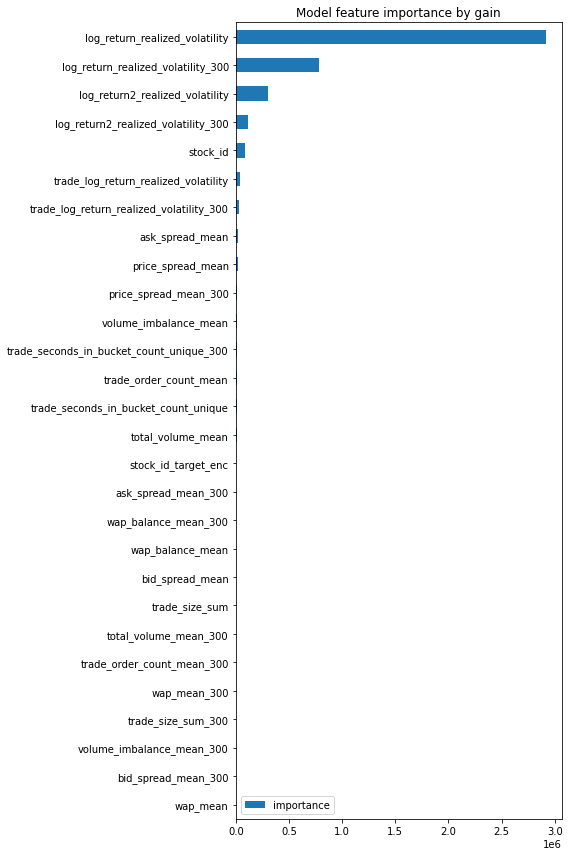

In [41]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

In [ ]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)